# QKeras RNN comparison


1. Create a model and compare its performance to the boosted model
2. If the model outreach the performance of the boosted model : 
 -   create a model with the same feature with qkeras (QAT) and 
 -   quantized the keras model (PTQ)
3. Compare those two to PTQ boosted model

The models with keras should converge to around 1e-5 or 9.8e-6

For QKeras it's been somewhere around 1.1e-5 or so



# To Run Everytime

## Imports

In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from collections import deque
from keras.regularizers import l2, l1, l1_l2

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *



2022-06-01 16:20:54.743434: I tensorflow/core/util/util.cc:168] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-01 16:20:54.749361: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 16:20:54.749378: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Load libraries if they are changed
%load_ext autoreload
%autoreload 2


In [3]:
boosted_model =  tf.keras.models.load_model('../pb_file')

boosted_model.summary()


2022-06-01 16:20:59.586520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-01 16:20:59.586552: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-01 16:20:59.586573: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martop): /proc/driver/nvidia/version does not exist
2022-06-01 16:20:59.586944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## Settings

In [4]:
# settings of the networks 
output = 1

nbr_batch =64
nbr_epoch = 200
lr=0.001

delta= 0.00000001

time_step = 5
weight_decay6=0.000001
weight_decay7=0.0000001
weight_decay58=0.00000005
weight_decay88=0.00000008
weight_decay8=0.00000001


nbr_conv_epoch = 4 #number of epochs for the conversion 
patience_es = 12

patience_rlr = 5


def units(j): return (j+8)
units_range = 1

def version(v): return v
versions_range = 3

In [5]:
#quantized settings
integer = 0


def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+8)

def bit_width(i): return {'bits': (i+8), 'integer': integer, 'symmetric': 0, 'alpha':1}

bits_range = 1

In [6]:
# path

#path of the tested models 
def models_path0(v) : return f"tests/models/model_decay{l1}={weight_decay6}_v{version(v)}.h5"
def predicts_path0(v) : return f"tests/predicts/model_decay{l1}={weight_decay6}_v{version(v)}.npy"

def models_path1(v) : return f"tests/models/model_decay{l2}={weight_decay6}_v{version(v)}.h5"
def predicts_path1(v) : return f"tests/predicts/model_decay{l2}={weight_decay6}_v{version(v)}.npy"

def models_path2(v) : return f"tests/models/model_decay{l2}={weight_decay7}_v{version(v)}.h5"
def predicts_path2(v) : return f"tests/predicts/model_decay{l2}={weight_decay7}_v{version(v)}.npy"

def models_path3(v) : return f"tests/models/model_decay{l2}={weight_decay88}_v{version(v)}.h5"
def predicts_path3(v) : return f"tests/predicts/model_decay{l2}={weight_decay88}_v{version(v)}.npy"

def models_path4(v) : return f"tests/models/model_decay{l2}={weight_decay58}_v{version(v)}.h5"
def predicts_path4(v) : return f"tests/predicts/model_decay{l2}={weight_decay58}_v{version(v)}.npy"

def models_path5(v) : return f"tests/models/model_decay{l2}={weight_decay8}_v{version(v)}.h5"
def predicts_path5(v) : return f"tests/predicts/model_decay{l2}={weight_decay8}_v{version(v)}.npy"



## Data creation

In [7]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../data/rdgap_mu140.h5")

x, x_val, x_test, y, y_val, y_test = ds()



shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


# 3. Compare the results

In [8]:
def exist(path, modeltopred):

    if (os.path.exists(path)==False):
        print(path)
        print('saving')
        np.save(path, modeltopred.predict(x_test))
        print('saved')
    else : print(f'{path} already exists')

In [9]:
ref_path = 'tests/ref_predicts.npy'
exist(ref_path, boosted_model)

tests/ref_predicts.npy already exists


## Predictions

### For keras

In [10]:
for v in range (versions_range):

    model0 = tf.keras.models.load_model(models_path0(v))
    exist(predicts_path0(v), model0)


    model1 = tf.keras.models.load_model(models_path1(v))
    exist(predicts_path1(v), model1)

    model2 = tf.keras.models.load_model(models_path2(v))
    exist(predicts_path2(v), model2)    
   
    model3 = tf.keras.models.load_model(models_path3(v))
    exist(predicts_path3(v), model3)

    model4 = tf.keras.models.load_model(models_path4(v))
    exist(predicts_path4(v), model4)

    model5 = tf.keras.models.load_model(models_path5(v))
    exist(predicts_path5(v), model5)
    

tests/predicts/model_decay<class 'keras.regularizers.L1'>=1e-06_v0.npy already exists
tests/predicts/model_decay<class 'keras.regularizers.L2'>=1e-06_v0.npy already exists
tests/predicts/model_decay<class 'keras.regularizers.L2'>=1e-07_v0.npy already exists
tests/predicts/model_decay<class 'keras.regularizers.L2'>=8e-08_v0.npy already exists
tests/predicts/model_decay<class 'keras.regularizers.L2'>=5e-08_v0.npy already exists
tests/predicts/model_decay<class 'keras.regularizers.L2'>=1e-08_v0.npy already exists
tests/predicts/model_decay<class 'keras.regularizers.L1'>=1e-06_v1.npy already exists
tests/predicts/model_decay<class 'keras.regularizers.L2'>=1e-06_v1.npy already exists
tests/predicts/model_decay<class 'keras.regularizers.L2'>=1e-07_v1.npy already exists
tests/predicts/model_decay<class 'keras.regularizers.L2'>=8e-08_v1.npy already exists
tests/predicts/model_decay<class 'keras.regularizers.L2'>=5e-08_v1.npy already exists
tests/predicts/model_decay<class 'keras.regularizers.L

[1.6720516e-05, 1.0860551e-05, 9.9454e-06, 1.0024757e-05, 1.0166451e-05, 1.01679e-05]
[1.1361663e-05, 1.1058228e-05, 1.0961064e-05, 9.945688e-06, 1.0102957e-05, 9.574151e-06]
[1.5443848e-05, 1.1604869e-05, 1.0007609e-05, 1.0632917e-05, 9.917636e-06, 9.751541e-06]


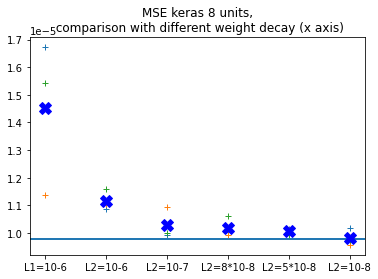

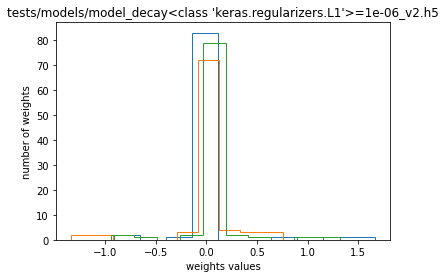

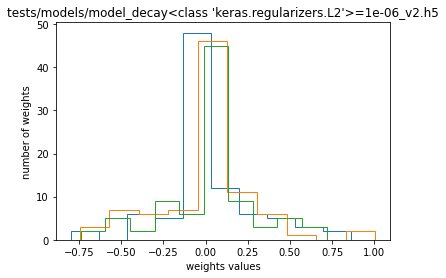

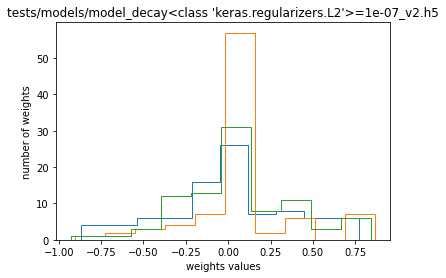

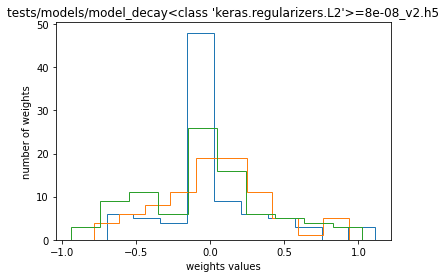

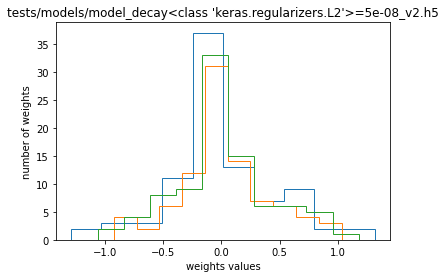

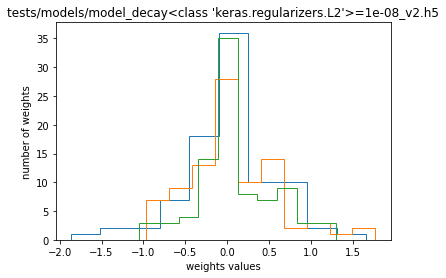

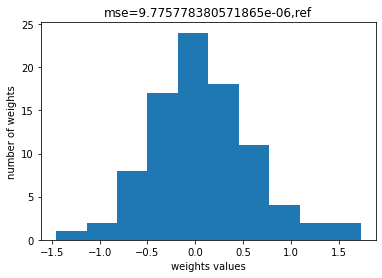

In [20]:
y_kerasref = np.load(ref_path)
lossref=mse(y_test,y_kerasref)

yaxis = []
sum1=0
sum2=0
sum3=0
sum4=0
sum5=0
sum0=0

yaxis.append('L1=10-6')
yaxis.append('L2=10-6')
yaxis.append('L2=10-7')
yaxis.append('L2=8*10-8')
yaxis.append('L2=5*10-8')

yaxis.append('L2=10-8')
mean =[]
for v in range (versions_range):

    loss1 = [] 
    y_keras6 = np.load(ref_path)
    y_keras0 = np.load(predicts_path0(v))
    y_keras1 = np.load(predicts_path1(v))
    y_keras2 = np.load(predicts_path2(v))
    y_keras3 = np.load(predicts_path3(v))
    y_keras4 = np.load(predicts_path4(v))
    y_keras5 = np.load(predicts_path5(v))
     
    sum0= sum0+mse(y_test,y_keras0)
    sum1= sum1+mse(y_test,y_keras1)
    sum2= sum2+mse(y_test,y_keras2)
    sum3= sum3+mse(y_test,y_keras3)
    sum4= sum4+mse(y_test,y_keras4)
    sum5= sum5+mse(y_test,y_keras5)
    
    loss1.append(mse(y_test,y_keras0))  
    loss1.append(mse(y_test,y_keras1))
    loss1.append(mse(y_test,y_keras2))        
    loss1.append(mse(y_test,y_keras3))     
    loss1.append(mse(y_test,y_keras4))     
    loss1.append(mse(y_test,y_keras5))     
    plt.axhline(mse(y_test,y_keras6))  
    plt.plot(loss1,'+')
    print(loss1)

mean.append((sum0/3))
mean.append((sum1/3))
mean.append((sum2/3))
mean.append((sum3/3))
mean.append((sum4/3))
mean.append((sum5/3))


plt.plot(mean,'X',color='blue',markersize=12)

plt.title(f'MSE keras 8 units,\n comparison with different weight decay (x axis)')
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])
plt.show()



plt.ylabel("number of weights")
plt.xlabel("weights values")
for v in range (versions_range):
    plt.hist(np.concatenate([i.flatten() for i in tf.keras.models.load_model(models_path0(v)).get_weights()]), histtype="step")

plt.title(f"{models_path0(v)}")
plt.show()


plt.figure()
plt.ylabel("number of weights")
plt.xlabel("weights values")
for v in range (versions_range):
    plt.hist(np.concatenate([i.flatten() for i in tf.keras.models.load_model(models_path1(v)).get_weights()]), histtype="step")
plt.title(f"{models_path1(v)}")
plt.show()

plt.figure()
plt.ylabel("number of weights")
plt.xlabel("weights values")
for v in range (versions_range):    
    plt.hist(np.concatenate([i.flatten() for i in tf.keras.models.load_model(models_path2(v)).get_weights()]), histtype="step")
plt.title(f"{models_path2(v)}")
plt.show()

plt.figure()
plt.ylabel("number of weights")
plt.xlabel("weights values")
for v in range (versions_range):
    plt.hist(np.concatenate([i.flatten() for i in tf.keras.models.load_model(models_path3(v)).get_weights()]), histtype="step")
plt.title(f"{models_path3(v)}")
plt.show()

plt.figure()
plt.ylabel("number of weights")
plt.xlabel("weights values")
for v in range (versions_range):
    plt.hist(np.concatenate([i.flatten() for i in tf.keras.models.load_model(models_path4(v)).get_weights()]), histtype="step")
plt.title(f"{models_path4(v)}")
plt.show()

plt.figure()
plt.ylabel("number of weights")
plt.xlabel("weights values")
for v in range (versions_range):
    plt.hist(np.concatenate([i.flatten() for i in tf.keras.models.load_model(models_path5(v)).get_weights()]), histtype="step")
plt.title(f"{models_path5(v)}")
plt.show()

plt.figure()
plt.ylabel("number of weights")
plt.xlabel("weights values")
plt.hist(np.concatenate([i.flatten() for i in boosted_model.get_weights()]))
plt.title(f"mse={lossref},ref")
plt.show()

### For Qkeras

In [10]:

for v in range (versions_range):
    j=0
    i=0

    qmodel1 = qkeras.utils.load_qmodel(qtrained_models_path(j,i,v)) 
    exist(qtrained_predicts_path(j,i,v), qmodel1) 
    qmodel2 = qkeras.utils.load_qmodel(qtrained_models_path2(j,i,v))
    exist(qtrained_predicts_path2(j,i,v), qmodel2) 
         
    qmodel3 = qkeras.utils.load_qmodel(qtrained_models_path3(j,i,v))        
    exist(qtrained_predicts_path3(j,i,v), qmodel3)
    qmodel4 = qkeras.utils.load_qmodel(qtrained_models_path4(j,i,v))        
    exist(qtrained_predicts_path4(j,i,v), qmodel4)
    qmodel5 = qkeras.utils.load_qmodel(qrefmodels_path(i))        
    exist(qrefpredicts_path(i), qmodel5)   

tests/qpredicts_test/qtrained/qmodels_units=8_epoch=200_patiencES=5_patienceRLR=3_delta=1e-10_cp,<8,0>,rkernel=2v0.npy already exists
tests/qpredicts_test/qtrained/qmodels_units=8_epoch=200_patiencES=5_patienceRLR=3_delta=1e-09,<8,0>,rkernel=2v0.npy already exists
tests/qpredicts_test/qtrained/qmodels_units=8_epoch=200_patiencES=16_patienceRLR=7_delta=1e-09,<8,0>,rkernel=2v0.npy already exists
tests/qpredicts_test/qtrained/qmodels_units=8_epoch=200_patiencES=12_patienceRLR=5_delta=1e-08,<8,0,rkernel=2>v0.npy already exists
qpredicts_epoch=4/qpredicts<8,0>.npy already exists
tests/qpredicts_test/qtrained/qmodels_units=8_epoch=200_patiencES=5_patienceRLR=3_delta=1e-10_cp,<8,0>,rkernel=2v1.npy already exists
tests/qpredicts_test/qtrained/qmodels_units=8_epoch=200_patiencES=5_patienceRLR=3_delta=1e-09,<8,0>,rkernel=2v1.npy already exists
tests/qpredicts_test/qtrained/qmodels_units=8_epoch=200_patiencES=16_patienceRLR=7_delta=1e-09,<8,0>,rkernel=2v1.npy already exists
tests/qpredicts_test/q

In [11]:
for v in range (versions_range):
    y_qkeras1 = np.load(qtrained_predicts_path(j,i,v))
    print('rest:<8,0>, rkernel<8.0>',mse(y_test,y_qkeras1))
for v in range (versions_range):
    y_qkeras2 = np.load(qtrained_predicts_path2(j,i,v))
    print('rest:<8,0>, rkernel<6.0>',mse(y_test,y_qkeras2))
for v in range (versions_range):
    y_qkeras3 = np.load(qtrained_predicts_path3(j,i,v))
    print('rest:<8,0>, rkernel<4.0>',mse(y_test,y_qkeras3))  
for v in range (versions_range):
    y_qkeras4 = np.load(qtrained_predicts_path4(j,i,v))
    print('rest:<8,0>, rkernel<2.0>',mse(y_test,y_qkeras4))    


rest:<8,0>, rkernel<8.0> 1.4570147e-05
rest:<8,0>, rkernel<8.0> 1.4171368e-05
rest:<8,0>, rkernel<8.0> 1.38025725e-05
rest:<8,0>, rkernel<6.0> 1.49605685e-05
rest:<8,0>, rkernel<6.0> 1.4608886e-05
rest:<8,0>, rkernel<6.0> 1.468703e-05
rest:<8,0>, rkernel<4.0> 1.4818796e-05
rest:<8,0>, rkernel<4.0> 1.38080795e-05
rest:<8,0>, rkernel<4.0> 1.371929e-05
rest:<8,0>, rkernel<2.0> 1.3366514e-05
rest:<8,0>, rkernel<2.0> 1.4368032e-05
rest:<8,0>, rkernel<2.0> 1.3569032e-05


[1.1981933e-05, 1.2034845e-05, 1.093289e-05, 1.1920184e-05, 1.9061952e-05, 9.775778e-06]
[1.2803593e-05, 1.2831303e-05, 1.17863065e-05, 1.0700691e-05, 1.9061952e-05, 9.775778e-06]
[1.3187369e-05, 1.2641142e-05, 1.1027703e-05, 1.1706385e-05, 1.9061952e-05, 9.775778e-06]
[1.1874639e-05, 1.3375705e-05, 1.2063947e-05, 1.2289292e-05, 1.9061952e-05, 9.775778e-06]
[1.1662366e-05, 1.20250825e-05, 1.2980661e-05, 1.2464392e-05, 1.9061952e-05, 9.775778e-06]
[1.2207298e-05, 1.351107e-05, 1.1895124e-05, 1.1532051e-05, 1.9061952e-05, 9.775778e-06]
[1.2393877e-05, 1.3170795e-05, 1.3478827e-05, 1.2416229e-05, 1.9061952e-05, 9.775778e-06]
[1.26406385e-05, 1.1713331e-05, 1.3042967e-05, 1.12773505e-05, 1.9061952e-05, 9.775778e-06]
[1.1121343e-05, 1.36477265e-05, 1.2054673e-05, 1.353617e-05, 1.9061952e-05, 9.775778e-06]
[1.1481197e-05, 1.2520866e-05, 1.2609797e-05, 1.2789157e-05, 1.9061952e-05, 9.775778e-06]


([<matplotlib.axis.XTick at 0x7f54a47ddd90>,
 [Text(0, 0, '<2,0>'),
  Text(1, 0, '<4,0>'),
  Text(2, 0, '<6,0>'),
  Text(3, 0, '<8,0>'),
  Text(4, 0, 'qref'),
  Text(5, 0, 'ref')])

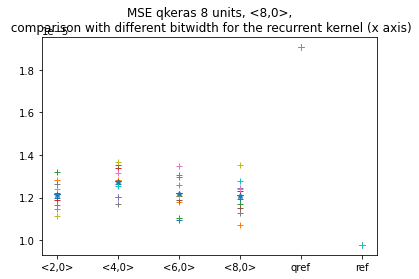

In [ ]:

loss1 = [] 
loss2 = [] 
loss3 = [] 
yaxis = []
sum1=0
sum2=0
sum3=0
sum4=0
j=0
i=0
yaxis.append('<2,0>')
yaxis.append('<4,0>')
yaxis.append('<6,0>')
yaxis.append('<8,0>')
yaxis.append('qref')
yaxis.append('ref')

for v in range (versions_range):
    loss1 = [] 
    y_qkeras5 = np.load(qrefpredicts_path(i))
    y_keras = np.load(ref_path)

    y_qkeras1 = np.load(qtrained_predicts_path(j,i,v))
    y_qkeras2 = np.load(qtrained_predicts_path2(j,i,v))
    y_qkeras3 = np.load(qtrained_predicts_path3(j,i,v))
    y_qkeras4 = np.load(qtrained_predicts_path4(j,i,v))
    sum1= sum1+mse(y_test,y_qkeras1)
    sum2= sum2+mse(y_test,y_qkeras2)
    sum3= sum3+mse(y_test,y_qkeras3)
    sum4= sum4+mse(y_test,y_qkeras4)
    loss1.append(mse(y_test,y_qkeras4)) 
    loss1.append(mse(y_test,y_qkeras3)) 
    loss1.append(mse(y_test,y_qkeras2))          
    loss1.append(mse(y_test,y_qkeras1)) 
    loss1.append(mse(y_test,y_qkeras5))  
    loss1.append(mse(y_test,y_keras))  
    plt.plot(loss1,'+')
    print(loss1)
loss2.append((sum4/10))
loss2.append((sum3/10))
loss2.append((sum2/10))
loss2.append((sum1/10))



plt.plot(loss2,'*')
#plt.legend(['bench 1','bench 2','bench 3','mean'])
plt.title(f'MSE qkeras {units(j)} units, <{bit_lenghts(i)},{integer}>,\n comparison with different bitwidth for the recurrent kernel (x axis)')
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])



[1.3366514e-05, 1.4818796e-05, 1.49605685e-05, 1.4570147e-05, 9.775778e-06]
[1.4368032e-05, 1.38080795e-05, 1.4608886e-05, 1.4171368e-05, 9.775778e-06]
[1.3569032e-05, 1.371929e-05, 1.468703e-05, 1.38025725e-05, 9.775778e-06]


([<matplotlib.axis.XTick at 0x7f37e41edc10>,
 [Text(0, 0, 'set4'),
  Text(1, 0, 'set3'),
  Text(2, 0, 'set2'),
  Text(3, 0, 'set1'),
  Text(4, 0, 'ref')])

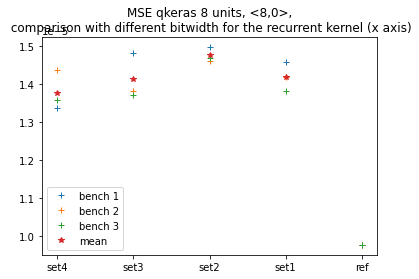

In [12]:
loss1 = [] 
loss2 = [] 
loss3 = [] 
yaxis = []
sum1=0
sum2=0
sum3=0
sum4=0
j=0
i=0

yaxis.append('set4')
yaxis.append('set3')
yaxis.append('set2')
yaxis.append('set1')

#yaxis.append('qref')
yaxis.append('ref')

for v in range (versions_range):
    loss1 = [] 
    y_qkeras5 = np.load(qrefpredicts_path(i))
    y_keras = np.load(ref_path)

    y_qkeras1 = np.load(qtrained_predicts_path(j,i,v))
    y_qkeras2 = np.load(qtrained_predicts_path2(j,i,v))
    y_qkeras3 = np.load(qtrained_predicts_path3(j,i,v))
    y_qkeras4 = np.load(qtrained_predicts_path4(j,i,v))
    sum1= sum1+mse(y_test,y_qkeras1)
    sum2= sum2+mse(y_test,y_qkeras2)
    sum3= sum3+mse(y_test,y_qkeras3)
    sum4= sum4+mse(y_test,y_qkeras4)
    loss1.append(mse(y_test,y_qkeras4)) 
    loss1.append(mse(y_test,y_qkeras3)) 
    loss1.append(mse(y_test,y_qkeras2))          
    loss1.append(mse(y_test,y_qkeras1)) 
    #loss1.append(mse(y_test,y_qkeras5))  
    loss1.append(mse(y_test,y_keras))  
    plt.plot(loss1,'+')
    print(loss1)
loss2.append((sum4/3))
loss2.append((sum3/3))
loss2.append((sum2/3))
loss2.append((sum1/3))



plt.plot(loss2,'*')
plt.legend(['bench 1','bench 2','bench 3','mean'])
plt.title(f'MSE qkeras {units(j)} units, <{bit_lenghts(i)},{integer}>,\n comparison with different bitwidth for the recurrent kernel (x axis)')
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])



## Plotting

### Keras

In [51]:

y_keras4 = np.load(ref_path)
loss1 = [] 
loss2 = []
loss3 = []
loss4 = []   
unit_nbr=[]
for j in range(units_range):
    y_keras1 = np.load(predicts_path1(j))
    y_keras2 = np.load(predicts_path2(j))
    y_keras3 = np.load(predicts_path3(j))

    unit_nbr.append(f'{units(j)}')
    
    loss1.append(mse(y_test,y_keras1))        
    loss2.append(mse(y_test,y_keras2))
    loss3.append(mse(y_test,y_keras3))
    loss4.append(mse(y_test,y_keras4))

plt.figure()
plt.subplot()
plt.plot(loss1)
plt.plot(loss2)
plt.plot(loss3)
plt.plot(loss4)

plt.legend(['delta = 0.00000001','delta = 0.0000001','delta = 0.0001','ref'])
plt.xticks(np.arange(len(unit_nbr)), [f"{Bit}" for Bit in unit_nbr])
plt.xlabel('units settings')
plt.yscale('log')
plt.ylabel('MSE')
plt.title(f'MSE keras X units, comparison with different min delta\n patience early stopping = {patience_es}, patiences reduce lr {patience_rlr}')
plt.show()

TypeError: predicts_path1() missing 1 required positional argument: 'v'

### qkeras

qpredicts_epoch=4/qpredicts<4,0>.npy
qpredicts_epoch=4/qpredicts<6,0>.npy
qpredicts_epoch=4/qpredicts<8,0>.npy
qpredicts_epoch=4/qpredicts<10,0>.npy
qpredicts_epoch=4/qpredicts<12,0>.npy


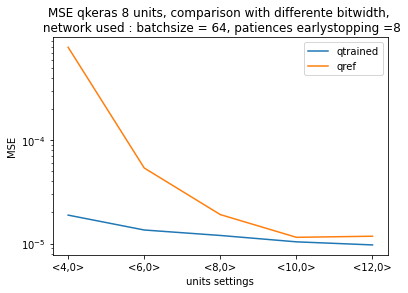

In [23]:

unit_nbr = []
for v in range (units_range):
    unit_nbr.append(f'{units(j)}')

    loss1 = [] 
    loss2 = []
    loss3 = []
    loss4 = []  
    bit_nbr = []
    for i in range(bits_range):
        print(qrefpredicts_path(i))
        y_keras4 = np.load(qrefpredicts_path(i))
        bit_nbr.append(bit_lenghts(i))
        y_qkeras1 = np.load(qtrained_predicts_path(j,i))
        #y_qkeras2 = np.load(qpredicts_path2(j,i))

        
        loss1.append(mse(y_test,y_qkeras1))        
        #loss2.append(mse(y_test,y_qkeras2))
        loss4.append(mse(y_test,y_keras4))

    plt.figure()
    plt.subplot()
    plt.plot(loss1)
    plt.plot(loss4)

    plt.legend(['qtrained','qref'])
    plt.xticks(np.arange(len(bit_nbr)), [f"<{Bit},{integer}>" for Bit in bit_nbr])
    plt.xlabel('units settings')
    plt.yscale('log')
    plt.ylabel('MSE')
    plt.title(f'MSE qkeras {units(j)} units, comparison with differente bitwidth, \n network used : batchsize = {nbr_batch}, patiences earlystopping =8')
plt.show()

In [22]:
print(mse(y_test,y_keras4))

9.775778e-06


In [14]:
import ROOT

Welcome to JupyROOT 6.26/02


In [35]:
import importlib
import nnDumper_standalone
importlib.reload(nnDumper_standalone)
#_,_, X_test,_,_,y_test = ds()

m_t = 16

dump_preds = nnDumper_standalone.dumper(start = 999997, name = "pulse_noise_15p", bt_len=80)

dump_preds.set_data(true = ds.hit, data = ds.dig, sig = ds.sig, ofmax = ds.ofmax)

#dump_preds.set_preds('rnn_seq5', m_t*rnn8_model.predict(X_test).flatten())
#dump_preds.set_preds('lstm_seq5', m_t*lstm_u10_model.predict(X_test).flatten())
#dump_preds.set_preds('lstm_no_dense', m_t*rnn8_model.predict(X_test).flatten())
dump_preds.set_preds('rnn_seq5', m_t*vanilla_sliding_psp8ns_model.predict(X_test).flatten())

dump_preds.runme()

ModuleNotFoundError: No module named 'nnDumper_standalone'